# Анализ минимальных решателей (RTE)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
pd.options.display.float_format = '{:.7f}'.format

### Характеристики оборудования:

Операционная система:

In [47]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="21.04 (Hirsute Hippo)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 21.04"
VERSION_ID="21.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=hirsute
UBUNTU_CODENAME=hirsute


CPU:

In [48]:
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "MHz"

Model name:                      Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
Socket(s):                       1
Core(s) per socket:              4
Thread(s) per core:              2
CPU MHz:                         711.746
CPU max MHz:                     3900,0000
CPU min MHz:                     400,0000


RAM:

In [52]:
!grep MemTotal /proc/meminfo

MemTotal:        8026900 kB


## Testing minimal solvers

In [9]:
esimators = {"median": np.median, "mean": np.mean}

In [10]:
def plot_estimators(x: str, y: str, xlabel: str, ylabel: str, hue: str, data: pd.DataFrame, title: str):
    fig, axes = plt.subplots(ncols=2, figsize=(18, 9))
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    fig.suptitle(title, fontsize=18)

    for i, (est_name, est) in enumerate(esimators.items()):
        sns.lineplot(
            ax=axes[i],
            x=x, 
            y=y, 
            hue=hue, 
            estimator=est,
            data=data
        )
        axes[i].set(ylabel=f"{ylabel} ({est_name})", xlabel=xlabel)

In [98]:
motion_df = pd.read_csv("./error_motion.csv")
stability_df = pd.read_csv("./error_stability.csv")
motion_inf_mask = motion_df["ATE"].isin([np.inf, -np.inf])
st_inf_mask = stability_df["ATE"].isin([np.inf, -np.inf])
motion_df = motion_df[~motion_inf_mask]
stability_df = stability_df[~st_inf_mask]

### Характеристики датасетов:

In [8]:
motion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method_name     35000 non-null  object 
 1   motion_length   35000 non-null  float64
 2   turning_angle   35000 non-null  float64
 3   experiment_num  35000 non-null  int64  
 4   ATE             35000 non-null  float64
 5   RTE             35000 non-null  float64
 6   ARE             35000 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.9+ MB


In [8]:
stability_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method_name     35000 non-null  object 
 1   scene_width     35000 non-null  float64
 2   scene_length    35000 non-null  float64
 3   angle_std       35000 non-null  float64
 4   experiment_num  35000 non-null  int64  
 5   ATE             35000 non-null  float64
 6   RTE             35000 non-null  float64
 7   ARE             35000 non-null  float64
 8   time            35000 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.4+ MB


### Основные статистики запросов:

In [60]:
motion_inf_mask = motion_df["ATE"].isin([np.inf, -np.inf])
motion_df[~motion_inf_mask].groupby(["method_name"])[["ARE", "ATE", "RTE"]].describe().T

method_name         17pt                   6pt  6pt_opengv_raw  6pt_poselib  \
ARE count   5000.0000000          5000.0000000    5000.0000000 4607.0000000   
    mean       0.0000000             0.6195550       2.9753834    0.0000238   
    std        0.0000000             0.7590388       0.1652857    0.0011290   
    min        0.0000000             0.0000000       0.5612220    0.0000000   
    25%        0.0000000             0.1906538       2.9005975    0.0000000   
    50%        0.0000000             0.3839240       3.0184300    0.0000000   
    75%        0.0000000             0.6581700       3.0935800    0.0000000   
    max        0.0000000             3.1415900       3.1415900    0.0703598   
ATE count   5000.0000000          5000.0000000    5000.0000000 4607.0000000   
    mean       1.1518704    2917926483.3473830      11.4999940    0.2790690   
    std        3.8570617   71402707296.6547699       5.4259558    1.9621171   
    min        0.0000000             0.0000000       3.0000000    0.0000000   
    25%        0.0000000            10.2553500       6.7777800    0.0000000   
    50%        0.0000000            16.1252500      11.5000000    0.0000000   
    75%        0.0000000            21.8793250      16.2222000    0.0000000   
    max       21.6041000 3263210000000.0000000      20.0000000   19.9481000   
RTE count   5000.0000000          5000.0000000    5000.0000000 4607.0000000   
    mean       0.1570800             1.3120620       1.5708000    0.0010376   
    std        0.4712871             0.3530130       0.0000000    0.0400875   
    min        0.0000000             0.0000000       1.5708000    0.0000000   
    25%        0.0000000             1.1668850       1.5708000    0.0000000   
    50%        0.0000000             1.4687400       1.5708000    0.0000000   
    75%        0.0000000             1.5708000       1.5708000    0.0000000   
    max        1.5708000             1.5708000       1.5708000    1.5708000   

method_name          8pt     8pt_colmap          c+s  
ARE count   5000.0000000   4999.0000000 5000.0000000  
    mean       0.1077391      0.1192210    0.0455314  
    std        0.1879761      0.2207242    0.2294730  
    min        0.0000001      0.0000004    0.0000000  
    25%        0.0000411      0.0000393    0.0000000  
    50%        0.0072494      0.0062097    0.0000000  
    75%        0.1486102      0.1555180    0.0000000  
    max        1.5972800      2.5030300    2.8464500  
ATE count   5000.0000000   4999.0000000 5000.0000000  
    mean      13.0546299     92.8494724    1.4994332  
    std      129.1819403   5698.1065094   13.6983328  
    min        0.0000142      0.0000139    0.0000000  
    25%        0.0113728      0.0110323    0.0000000  
    50%        3.4034200      2.9109400    0.0000000  
    75%       13.0844750     11.5918000    0.0000000  
    max     8203.2600000 402789.0000000  693.9400000  
RTE count   5000.0000000   4999.0000000 5000.0000000  
    mean       0.6722698      0.2235537    0.0907250  
    std        0.7558749      0.3594416    0.3571761  
    min        0.0000001      0.0000001    0.0000000  
    25%        0.0000500      0.0000463    0.0000000  
    50%        0.0303025      0.0079690    0.0000000  
    75%        1.5708000      0.3678355    0.0000000  
    max        1.5708000      1.5550800    1.5708000

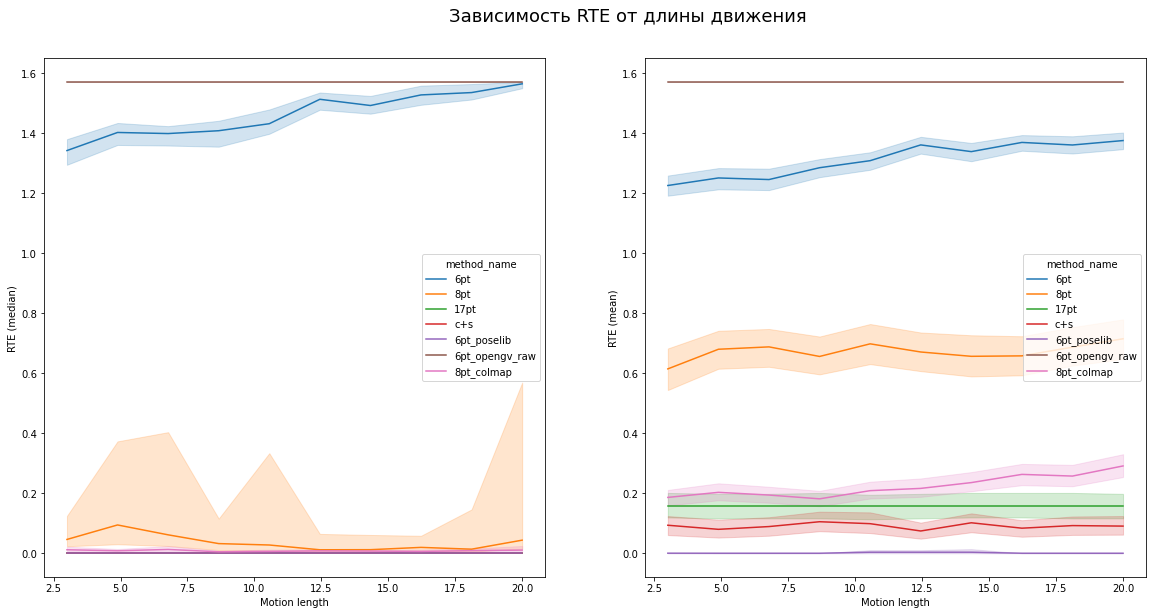

In [99]:
plot_estimators(
    x="motion_length", 
    y="RTE", 
    xlabel="Motion length", 
    ylabel="RTE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость RTE от длины движения"
);

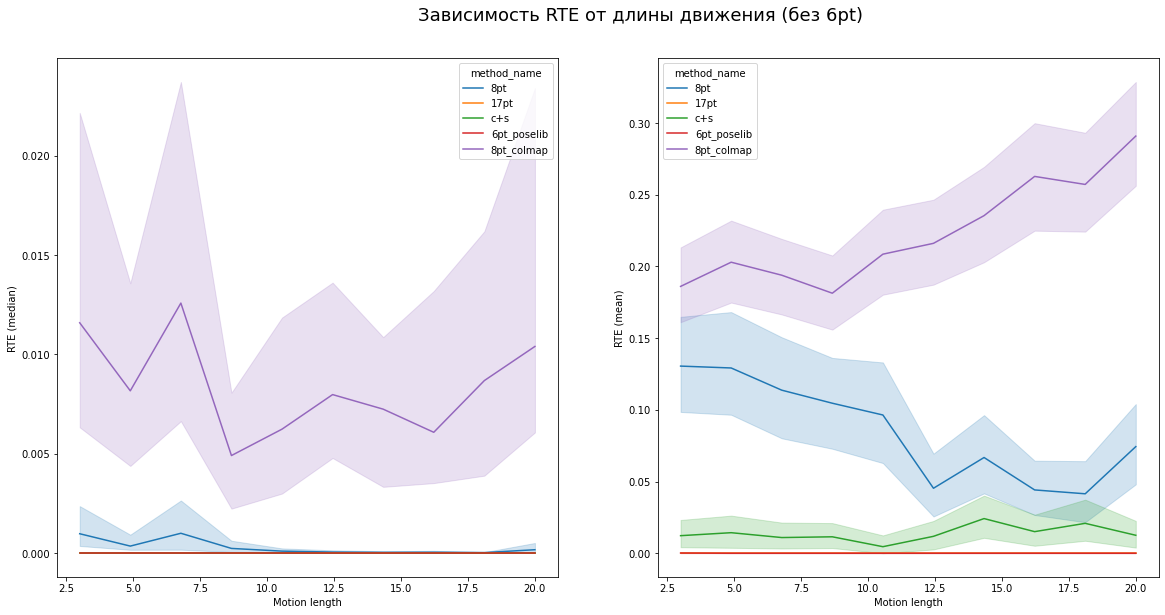

In [100]:
plot_estimators(
    x="motion_length", 
    y="RTE", 
    xlabel="Motion length", 
    ylabel="RTE", 
    hue="method_name", 
    data=motion_df[~motion_df['method_name'].isin(["6pt", "6pt_opengv_raw"]) & (motion_df["RTE"] < motion_df["RTE"].quantile(.95))], 
    title="Зависимость RTE от длины движения (без 6pt)"
);

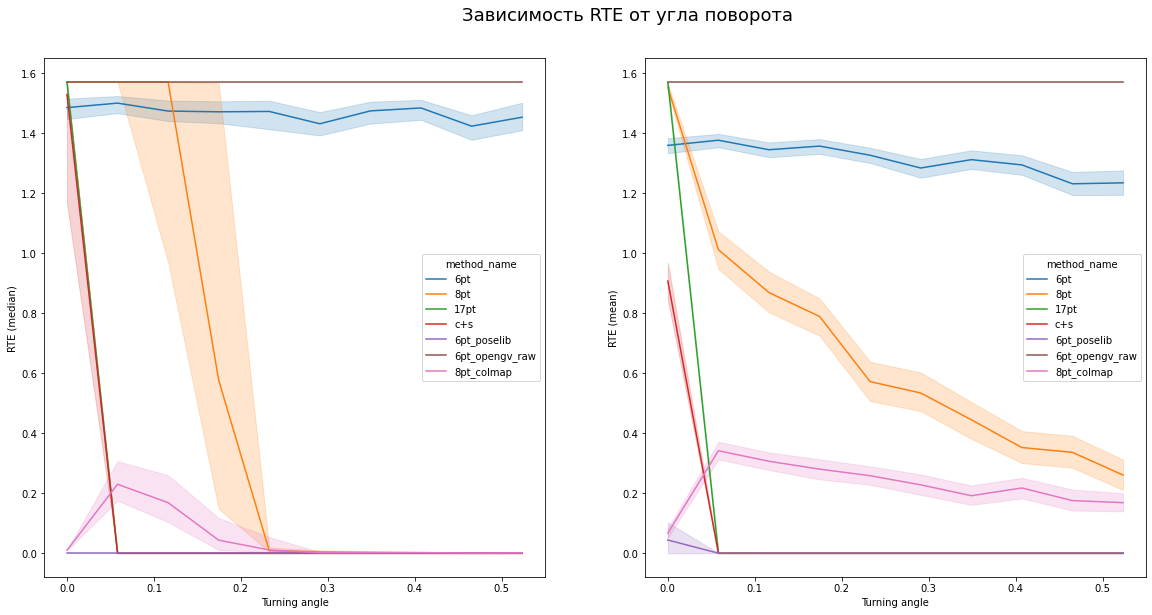

In [101]:
plot_estimators(
    x="turning_angle", 
    y="RTE", 
    xlabel="Turning angle", 
    ylabel="RTE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость RTE от угла поворота"
)

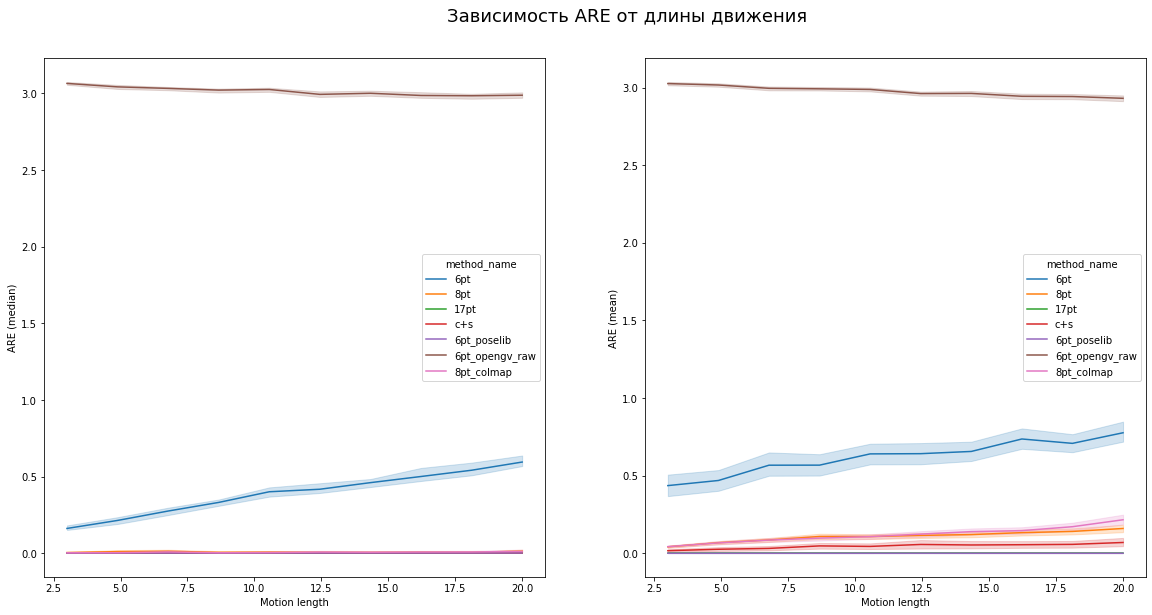

In [102]:
plot_estimators(
    x="motion_length", 
    y="ARE", 
    xlabel="Motion length", 
    ylabel="ARE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость ARE от длины движения"
)

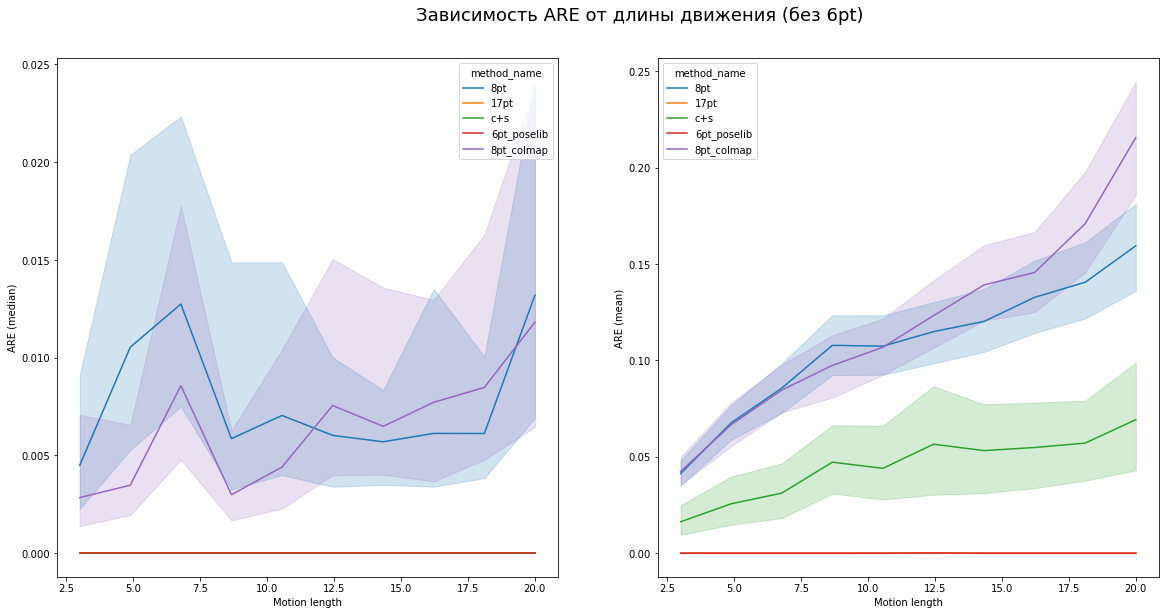

In [103]:
plot_estimators(
    x="motion_length", 
    y="ARE", 
    xlabel="Motion length", 
    ylabel="ARE", 
    hue="method_name", 
    data=motion_df[~motion_df['method_name'].isin(["6pt", "6pt_opengv_raw"])], 
    title="Зависимость ARE от длины движения (без 6pt)"
)

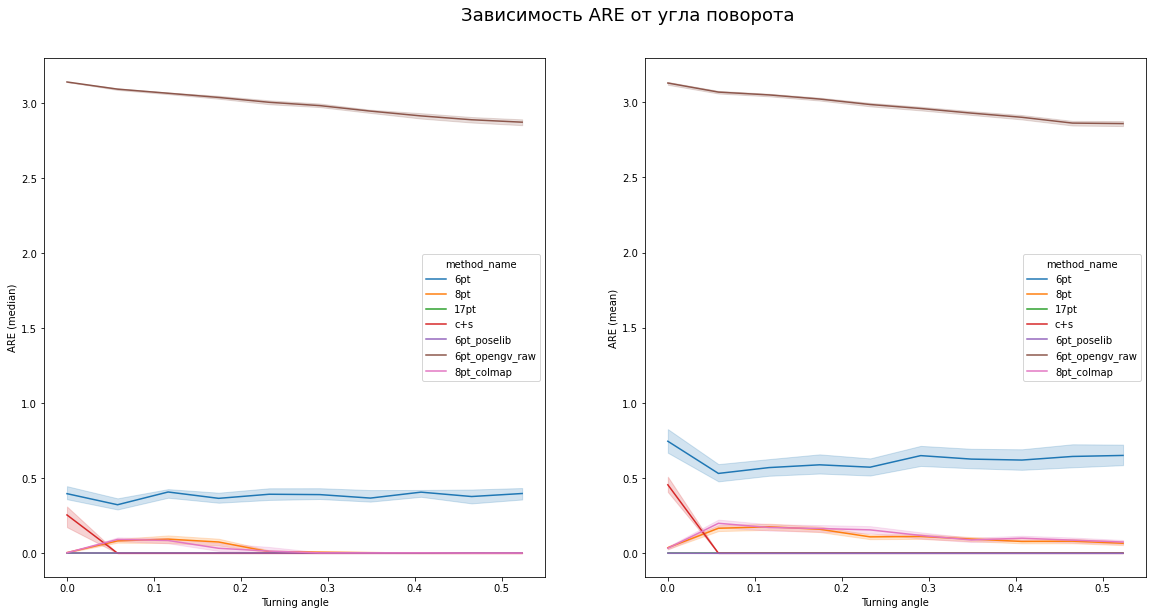

In [65]:
plot_estimators(
    x="turning_angle", 
    y="ARE", 
    xlabel="Turning angle", 
    ylabel="ARE", 
    hue="method_name", 
    data=motion_df, 
    title="Зависимость ARE от угла поворота"
)

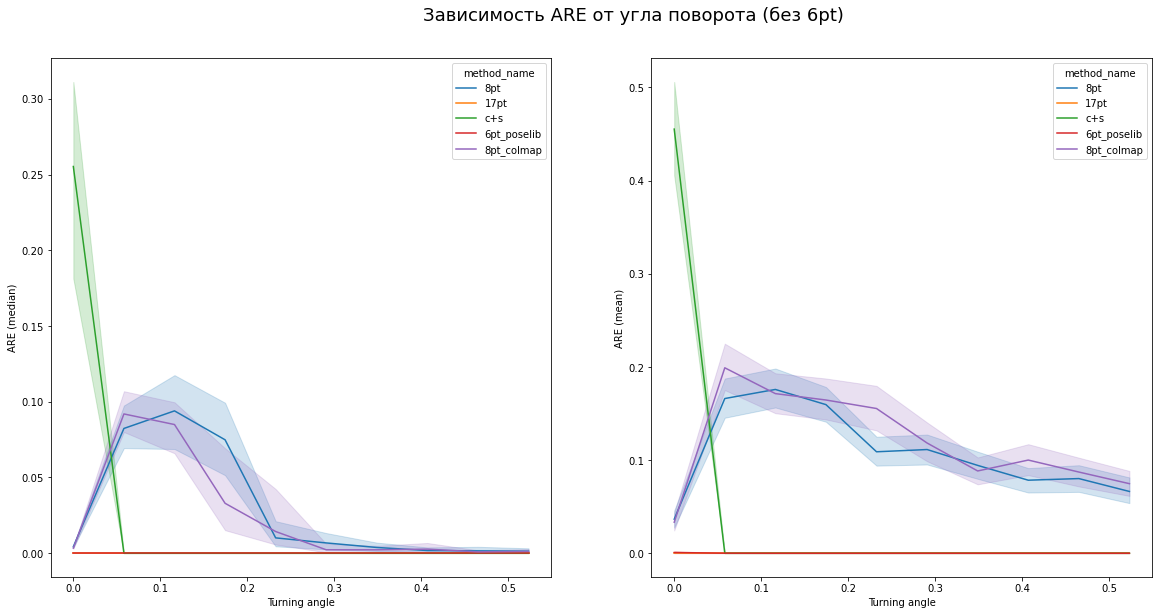

In [95]:
plot_estimators(
    x="turning_angle", 
    y="ARE", 
    xlabel="Turning angle", 
    ylabel="ARE", 
    hue="method_name", 
    data=motion_df[~motion_df['method_name'].isin(["6pt", "6pt_opengv_raw"])], 
    title="Зависимость ARE от угла поворота (без 6pt)"
)

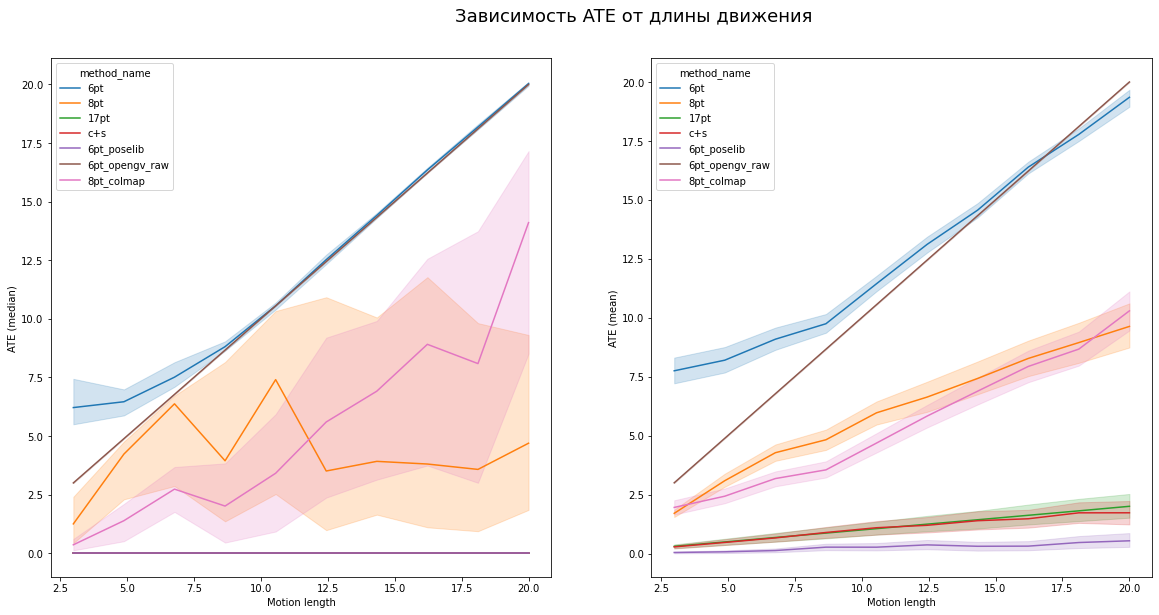

In [66]:
plot_estimators(
    x="motion_length", 
    y="ATE", 
    xlabel="Motion length", 
    ylabel="ATE", 
    hue="method_name", 
    data=motion_df[motion_df["ATE"] < motion_df["ATE"].quantile(.95)],
    title="Зависимость ATE от длины движения"
)

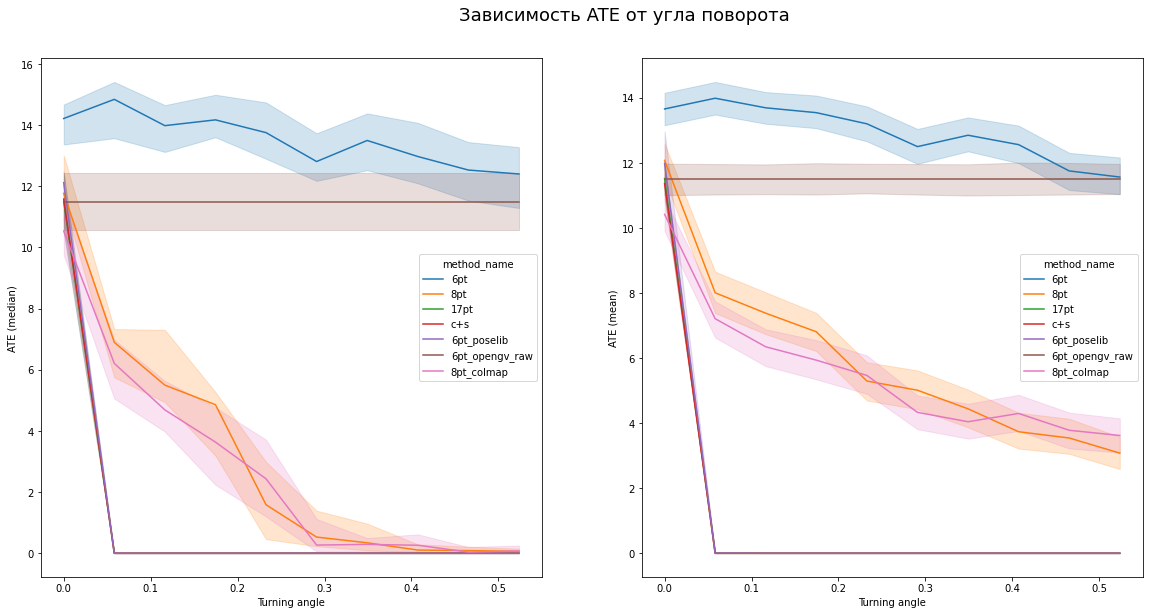

In [67]:
plot_estimators(
    x="turning_angle", 
    y="ATE", 
    xlabel="Turning angle", 
    ylabel="ATE", 
    hue="method_name", 
    data=motion_df[motion_df["ATE"] < motion_df["ATE"].quantile(.95)], 
    title="Зависимость ATE от угла поворота"
)

## Тестирование стабильности 

In [68]:
stability_df.groupby(["method_name"])[["ARE", "ATE", "RTE", "time"]].describe().T

method_name         17pt                   6pt  6pt_opengv_raw  6pt_poselib  \
ARE  count  5000.0000000          5000.0000000    5000.0000000 4651.0000000   
     mean      0.0263677             0.4236463       2.5272678    0.0148443   
     std       0.0613051             0.6943426       0.4483461    0.0502000   
     min       0.0000000             0.0000000       0.5276570    0.0000000   
     25%       0.0045929             0.0845420       2.2277350    0.0016406   
     50%       0.0125642             0.1965340       2.6145050    0.0048686   
     75%       0.0287964             0.3977888       2.9064950    0.0120708   
     max       2.9499600             3.1410500       3.1415000    1.1504400   
ATE  count  5000.0000000          5000.0000000    5000.0000000 4651.0000000   
     mean      0.7267143     753114491.8168181       5.0000000    0.7550406   
     std       1.0912972   46215026049.0047836       0.0000000    7.9342266   
     min       0.0000000             0.0000004       5.0000000    0.0000000   
     25%       0.0968076             4.6852075       5.0000000    0.0520824   
     50%       0.3163240             5.2057800       5.0000000    0.1690570   
     75%       0.8071403             5.8160450       5.0000000    0.4929900   
     max       7.0155600 3254830000000.0000000       5.0000000  512.7760000   
RTE  count  5000.0000000          5000.0000000    5000.0000000 4651.0000000   
     mean      0.1022094             1.2083052       1.5708000    0.0469499   
     std       0.2328359             0.4863900       0.0000000    0.1149618   
     min       0.0000000             0.0000001       1.5708000    0.0000000   
     25%       0.0083290             1.0015825       1.5708000    0.0044260   
     50%       0.0291344             1.4545300       1.5708000    0.0147502   
     75%       0.0845618             1.5708000       1.5708000    0.0412677   
     max       1.5708000             1.5708000       1.5708000    1.5708000   
time count  5000.0000000          5000.0000000    5000.0000000 4651.0000000   
     mean      0.0000489             0.0015409       0.0014068    0.0009734   
     std       0.0000075             0.0001095       0.0001093    0.0000816   
     min       0.0000411             0.0012614       0.0011575    0.0007802   
     25%       0.0000461             0.0014695       0.0013366    0.0009190   
     50%       0.0000472             0.0015226       0.0013872    0.0009620   
     75%       0.0000487             0.0015886       0.0014514    0.0010145   
     max       0.0001537             0.0025319       0.0023800    0.0014470   

method_name          8pt   8pt_colmap             c+s  
ARE  count  5000.0000000 5000.0000000    5000.0000000  
     mean      0.0372157    0.0565540       0.0388986  
     std       0.0699573    0.0893674       0.0947077  
     min       0.0000003    0.0000004       0.0000000  
     25%       0.0017767    0.0027670       0.0061890  
     50%       0.0050164    0.0137162       0.0187797  
     75%       0.0429291    0.0774835       0.0452733  
     max       0.6047860    1.0327000       2.8955600  
ATE  count  5000.0000000 5000.0000000    5000.0000000  
     mean      7.1365178    7.7927118     399.0826862  
     std     102.2093568   68.4175476   27581.8604367  
     min       0.0000033    0.0000115       0.0000000  
     25%       0.0506683    0.0790298       0.2384930  
     50%       0.1787480    0.4967300       1.0215050  
     75%       2.1118475    4.1637625       3.4239050  
     max    5494.5600000 2114.3600000 1950300.0000000  
RTE  count  5000.0000000 5000.0000000    5000.0000000  
     mean      0.2145332    0.2388717       0.3247910  
     std       0.4256810    0.3667931       0.4913566  
     min       0.0000001    0.0000012       0.0000000  
     25%       0.0050212    0.0072442       0.0227192  
     50%       0.0169805    0.0376597       0.0900643  
     75%       0.1561723    0.3264840       0.3502962  
     max       1.5708000    1.5101100       1.57

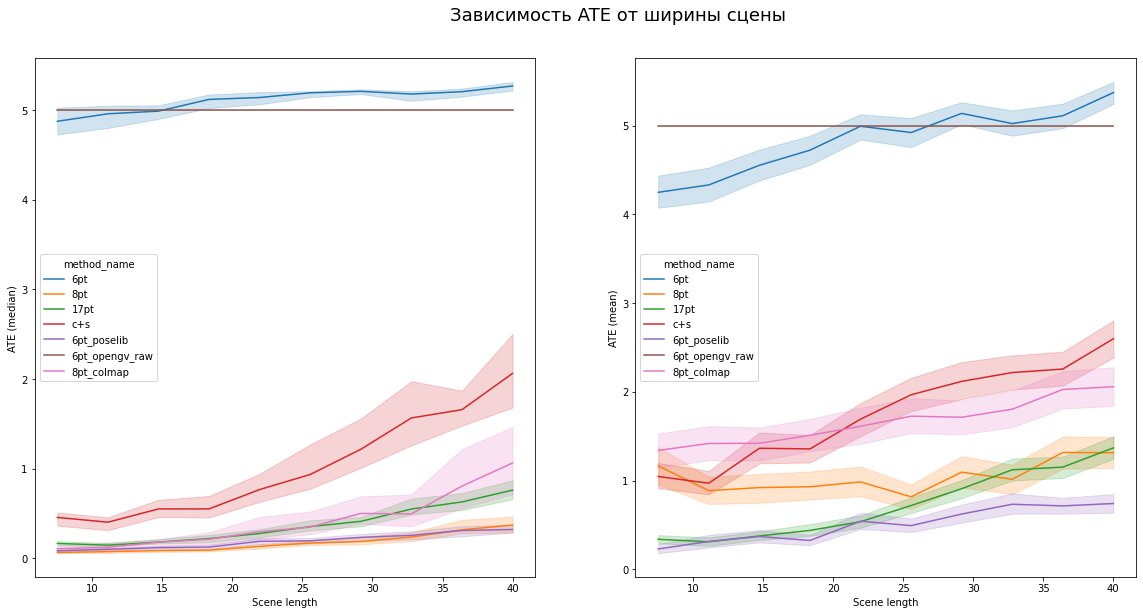

In [70]:
plot_estimators(
    x="scene_length", 
    y="ATE", 
    xlabel="Scene length", 
    ylabel="ATE", 
    hue="method_name", 
    data=stability_df[stability_df["ATE"] < stability_df["ATE"].quantile(.95)], 
    title="Зависимость ATE от ширины сцены"
)

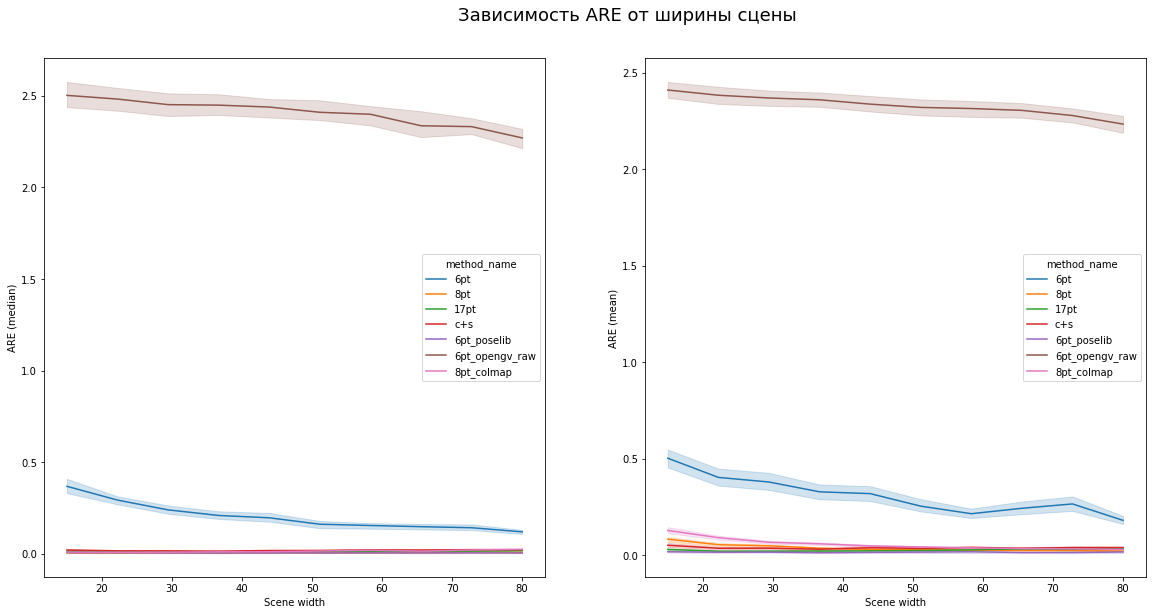

In [71]:
plot_estimators(
    x="scene_width", 
    y="ARE", 
    xlabel="Scene width", 
    ylabel="ARE", 
    hue="method_name", 
    data=stability_df[stability_df["ARE"] < stability_df["ARE"].quantile(.95)], 
    title="Зависимость ARE от ширины сцены"
)

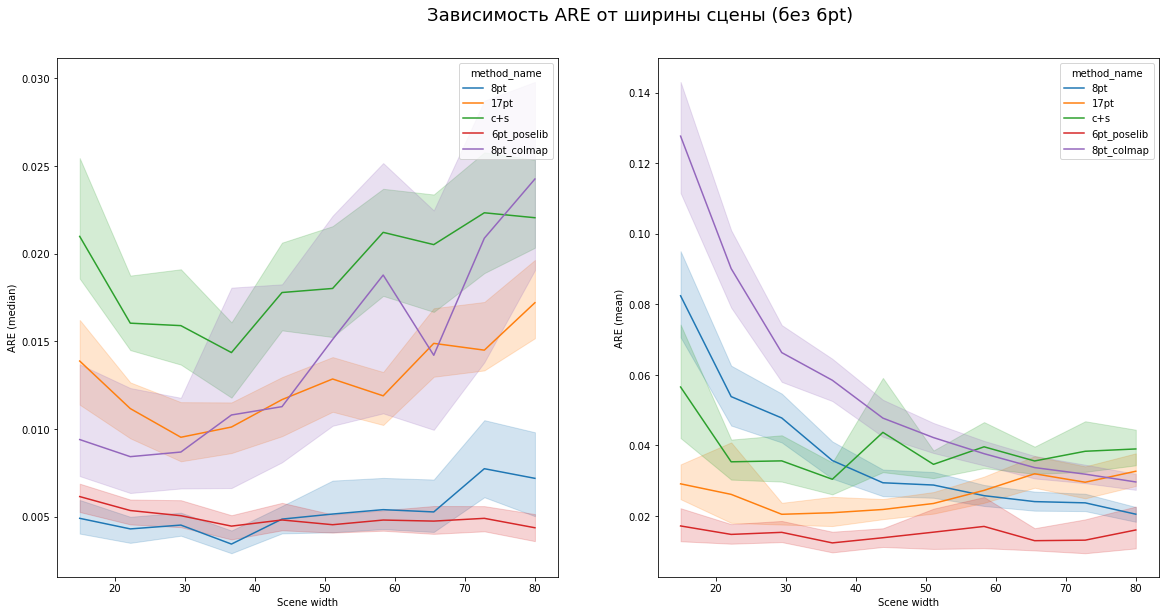

In [75]:
plot_estimators(
    x="scene_width", 
    y="ARE", 
    xlabel="Scene width", 
    ylabel="ARE", 
    hue="method_name", 
    data=stability_df[~stability_df["method_name"].isin(["6pt_opengv_raw", "6pt"])], 
    title="Зависимость ARE от ширины сцены (без 6pt)"
)

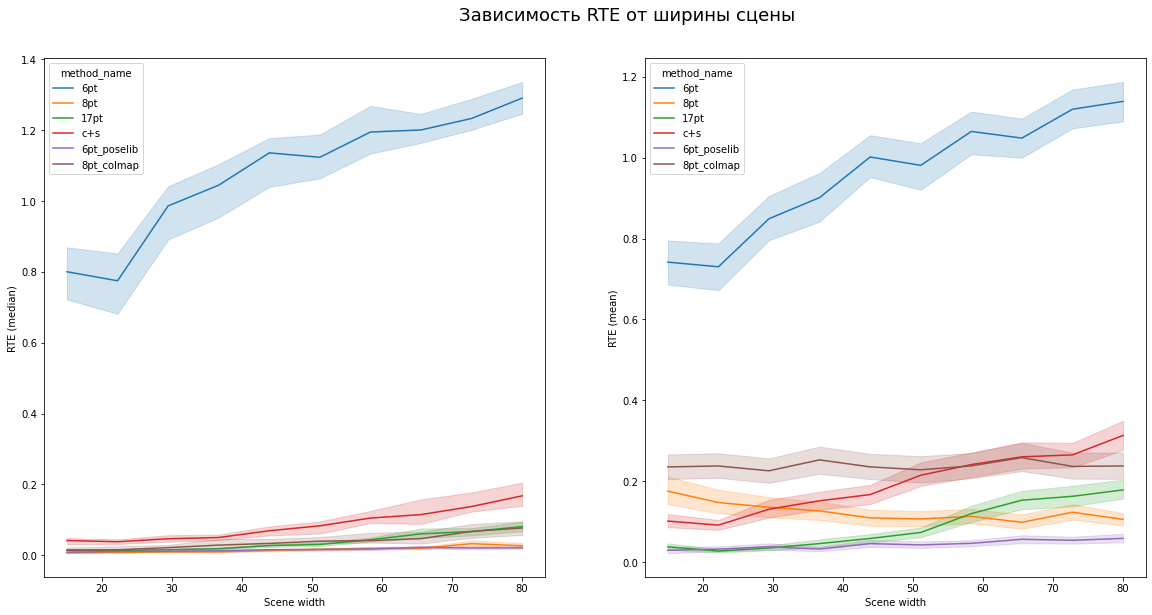

In [76]:
plot_estimators(
    x="scene_width", 
    y="RTE", 
    xlabel="Scene width", 
    ylabel="RTE", 
    hue="method_name", 
    data=stability_df[stability_df["RTE"] < stability_df["RTE"].quantile(.95)], 
    title="Зависимость RTE от ширины сцены"
)

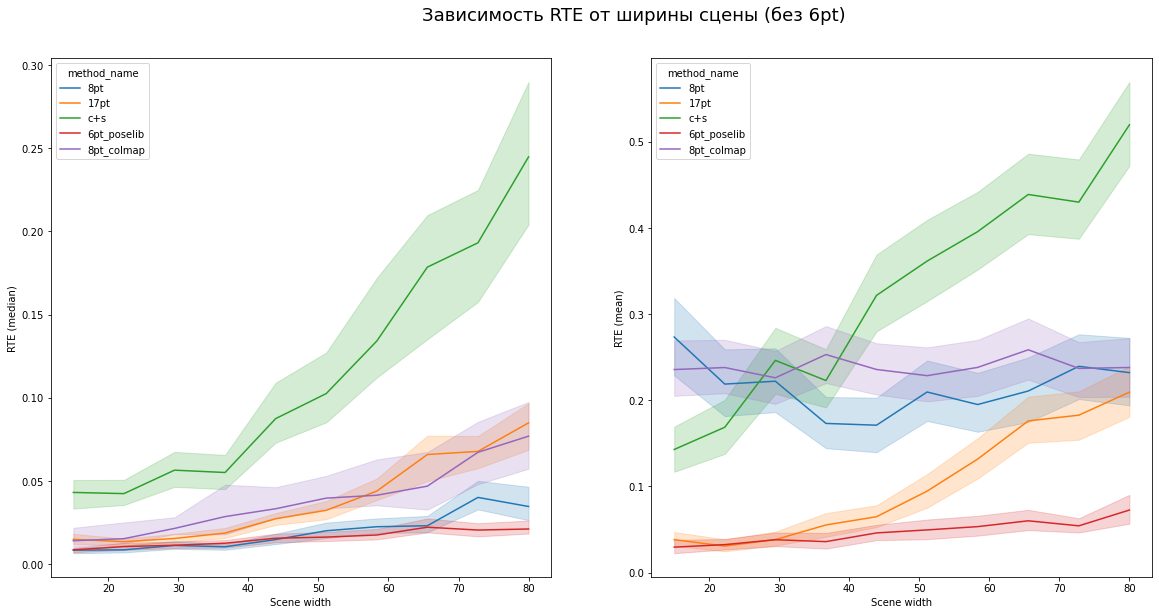

In [77]:
plot_estimators(
    x="scene_width", 
    y="RTE", 
    xlabel="Scene width", 
    ylabel="RTE", 
    hue="method_name", 
    data=stability_df[~stability_df["method_name"].isin(["6pt_opengv_raw", "6pt"])], 
    title="Зависимость RTE от ширины сцены (без 6pt)"
)

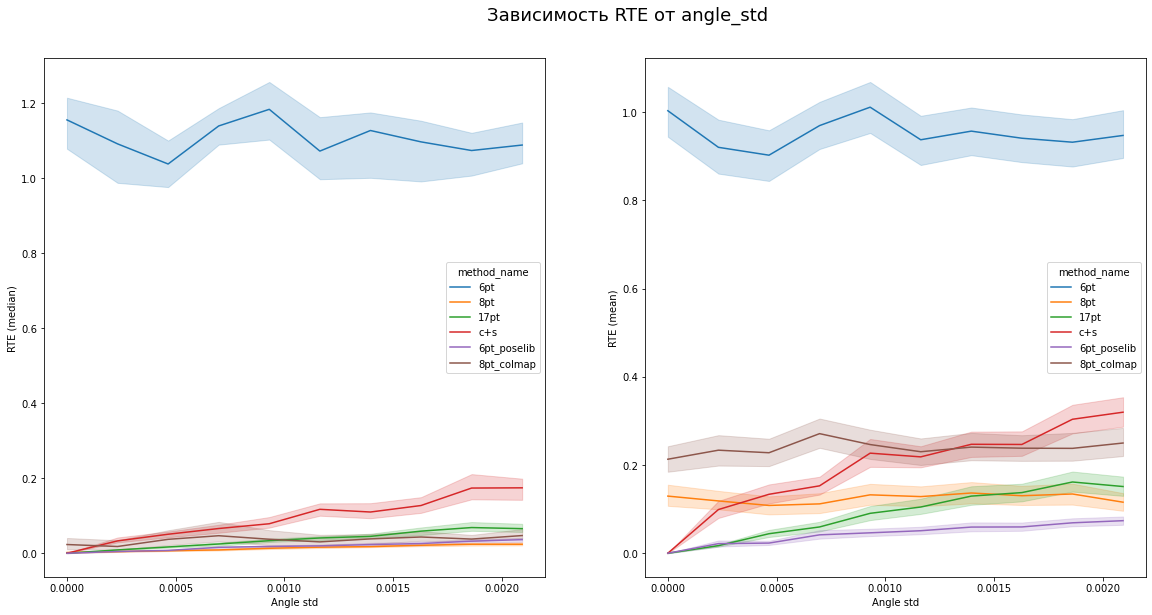

In [80]:
plot_estimators(
    x="angle_std", 
    y="RTE", 
    xlabel="Angle std", 
    ylabel="RTE", 
    hue="method_name", 
    data=stability_df[stability_df["RTE"] < stability_df["RTE"].quantile(.95)], 
    title="Зависимость RTE от angle_std"
)

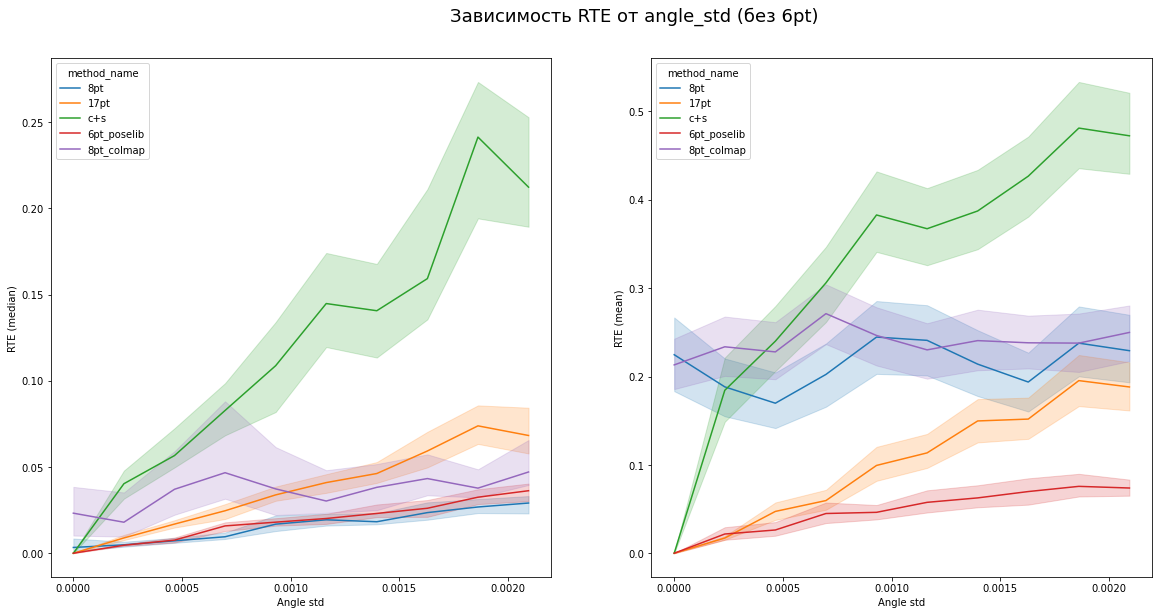

In [81]:
plot_estimators(
    x="angle_std", 
    y="RTE", 
    xlabel="Angle std", 
    ylabel="RTE", 
    hue="method_name", 
    data=stability_df[~stability_df["method_name"].isin(["6pt_opengv_raw", "6pt"])], 
    title="Зависимость RTE от angle_std (без 6pt)"
)

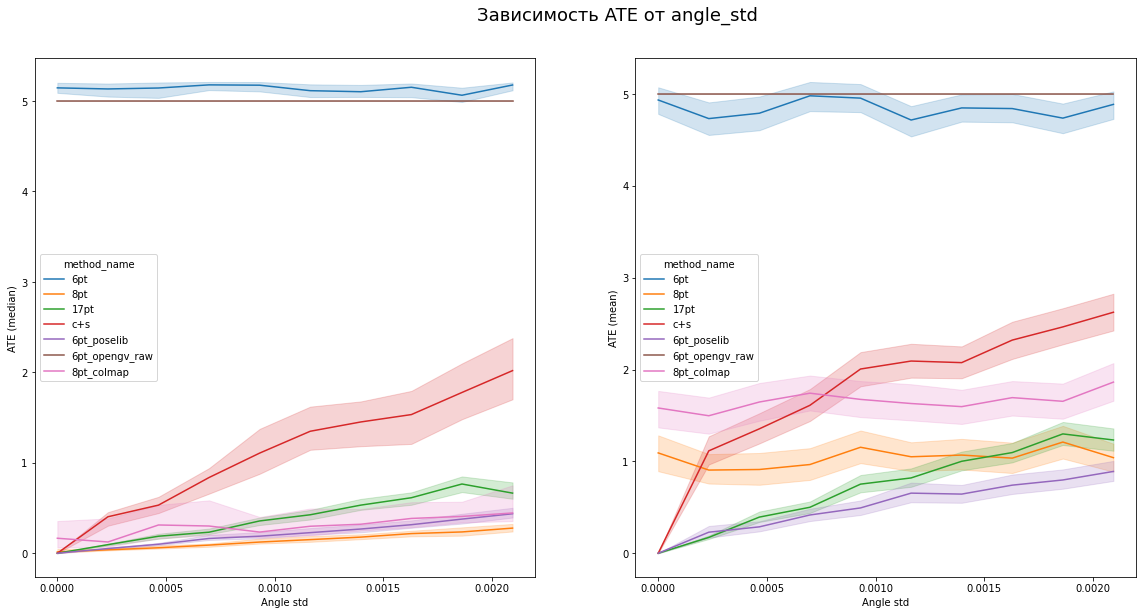

In [82]:
plot_estimators(
    x="angle_std", 
    y="ATE", 
    xlabel="Angle std", 
    ylabel="ATE", 
    hue="method_name", 
    data=stability_df[stability_df["ATE"] < stability_df["ATE"].quantile(.95)], 
    title="Зависимость ATE от angle_std"
)

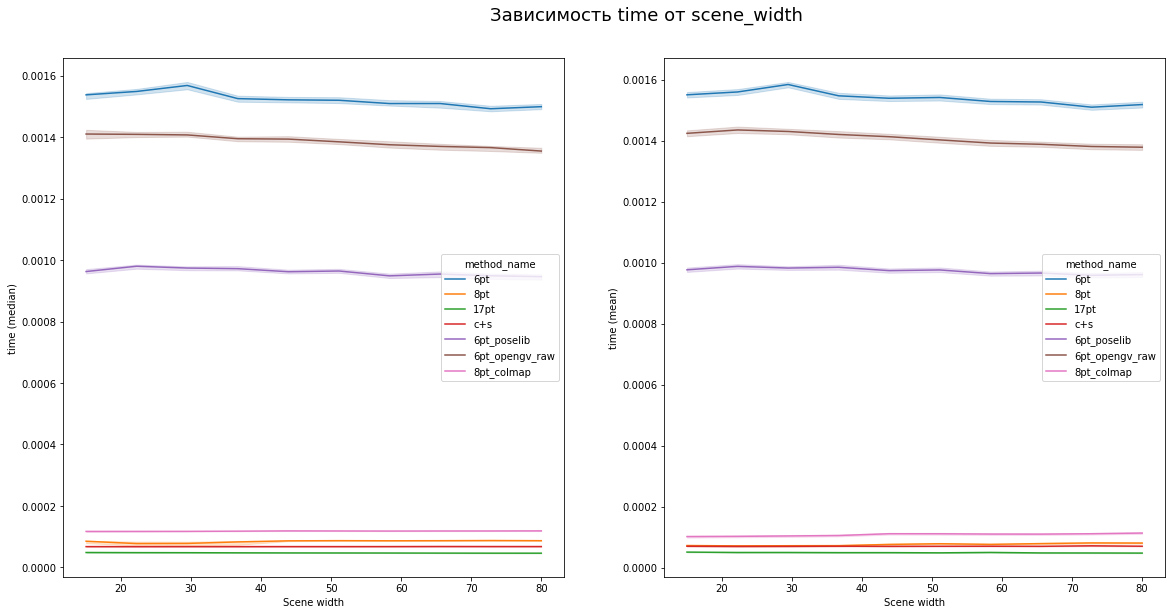

In [92]:
plot_estimators(
    x="scene_width", 
    y="time", 
    xlabel="Scene width", 
    ylabel="time", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость time от scene_width"
)

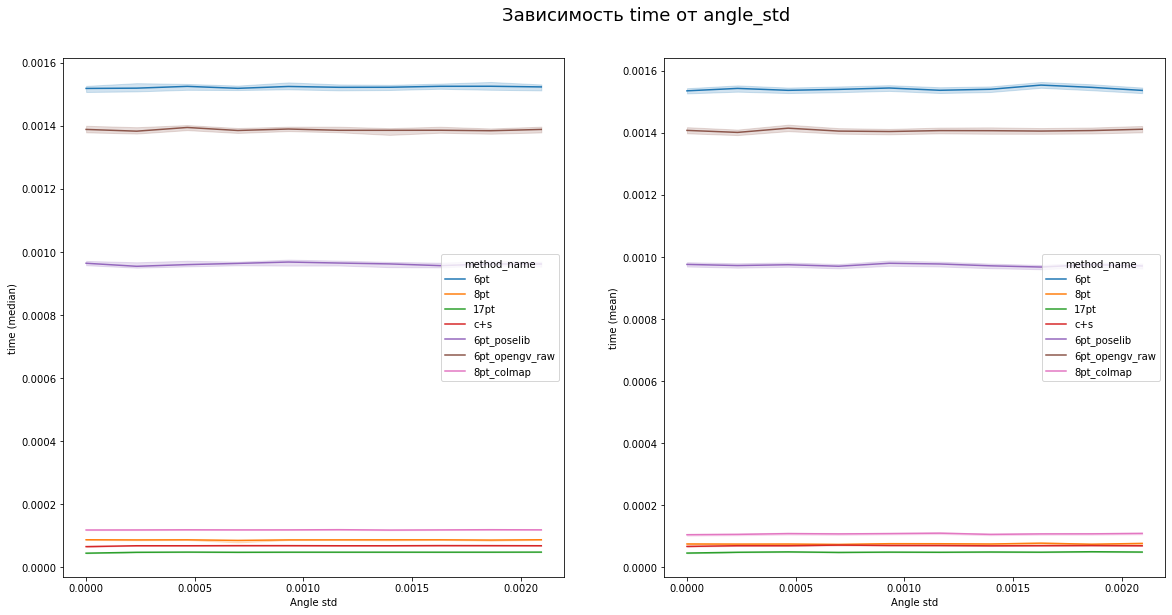

In [84]:
plot_estimators(
    x="angle_std", 
    y="time", 
    xlabel="Angle std", 
    ylabel="time", 
    hue="method_name", 
    data=stability_df, 
    title="Зависимость time от angle_std"
)

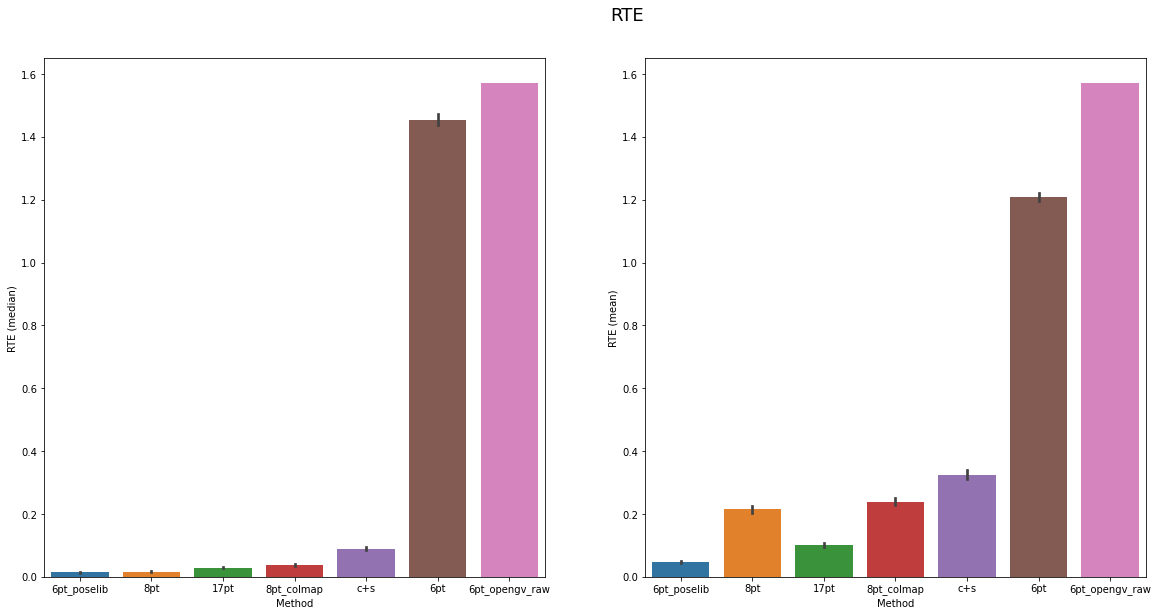

In [108]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('RTE', fontsize=18)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df.groupby(["method_name"])['RTE'].aggregate(np.median).reset_index().sort_values('RTE')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="RTE", 
            data=stability_df,
            estimator=est,
            order=order['method_name']
        )
        axes[i].set(ylabel=f"RTE ({est_name})", xlabel="Method")


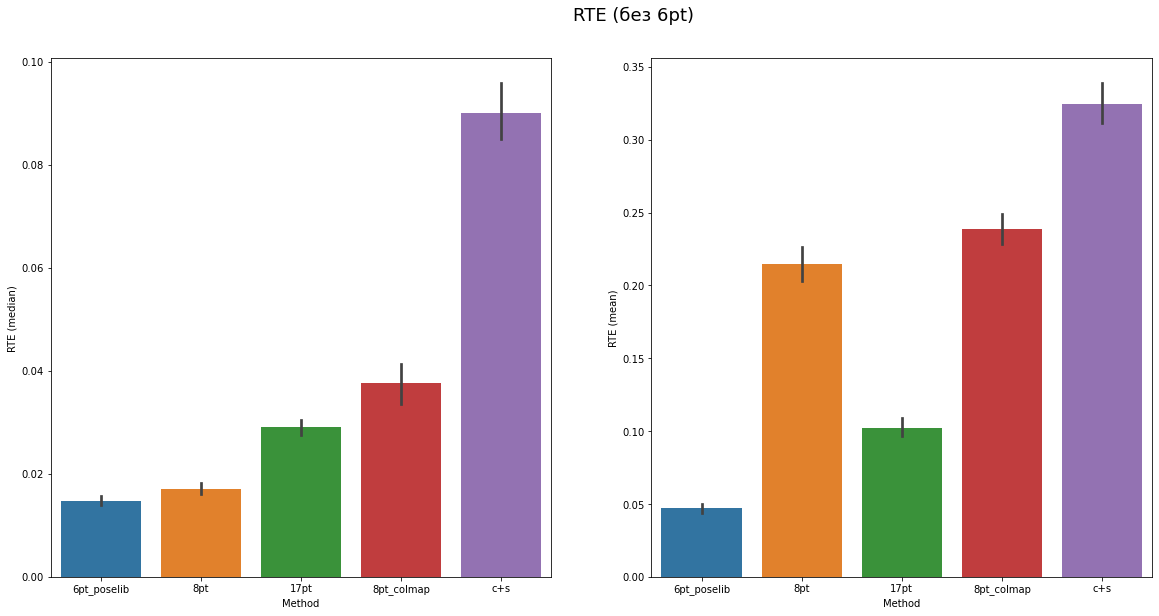

In [118]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('RTE (без 6pt)', fontsize=18)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df[~stability_df["method_name"].isin(["6pt", "6pt_opengv_raw"])].groupby(["method_name"])['RTE'].aggregate(np.median).reset_index().sort_values('RTE')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="RTE", 
            data=stability_df[~stability_df["method_name"].isin(["6pt", "6pt_opengv_raw"])],
            estimator=est,
            order=order['method_name']
        )
        axes[i].set(ylabel=f"RTE ({est_name})", xlabel="Method")

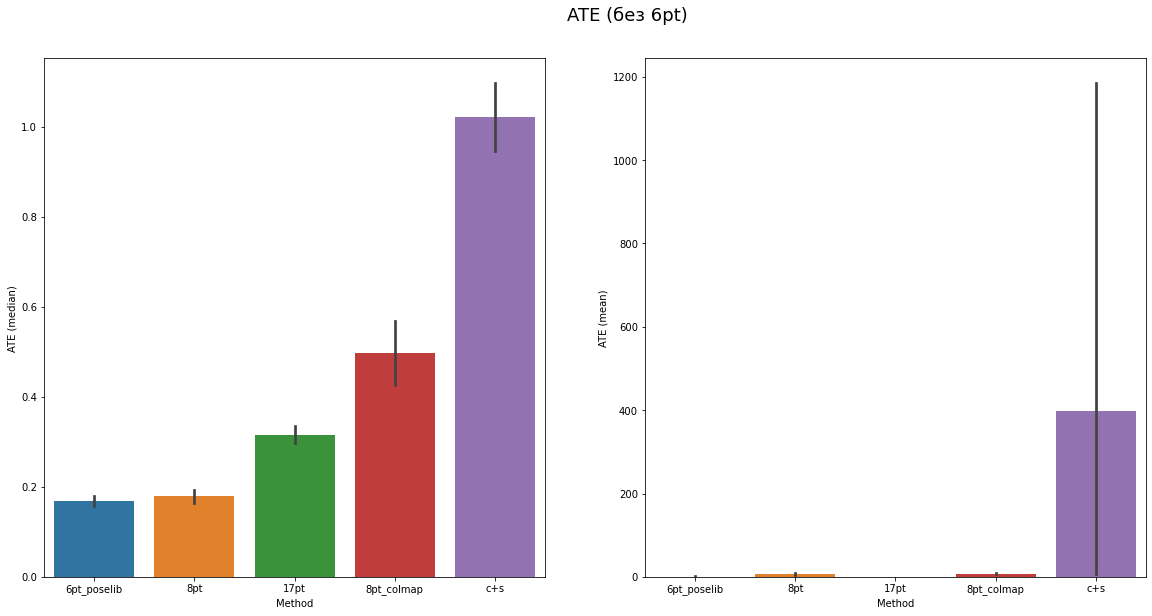

In [119]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('ATE (без 6pt)', fontsize=18)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df[~stability_df["method_name"].isin(["6pt", "6pt_opengv_raw"])].groupby(["method_name"])['ATE'].aggregate(np.median).reset_index().sort_values('ATE')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="ATE", 
            data=stability_df[~stability_df["method_name"].isin(["6pt", "6pt_opengv_raw"])],
            estimator=est,
            order=order['method_name']
        )
        axes[i].set(ylabel=f"ATE ({est_name})", xlabel="Method")

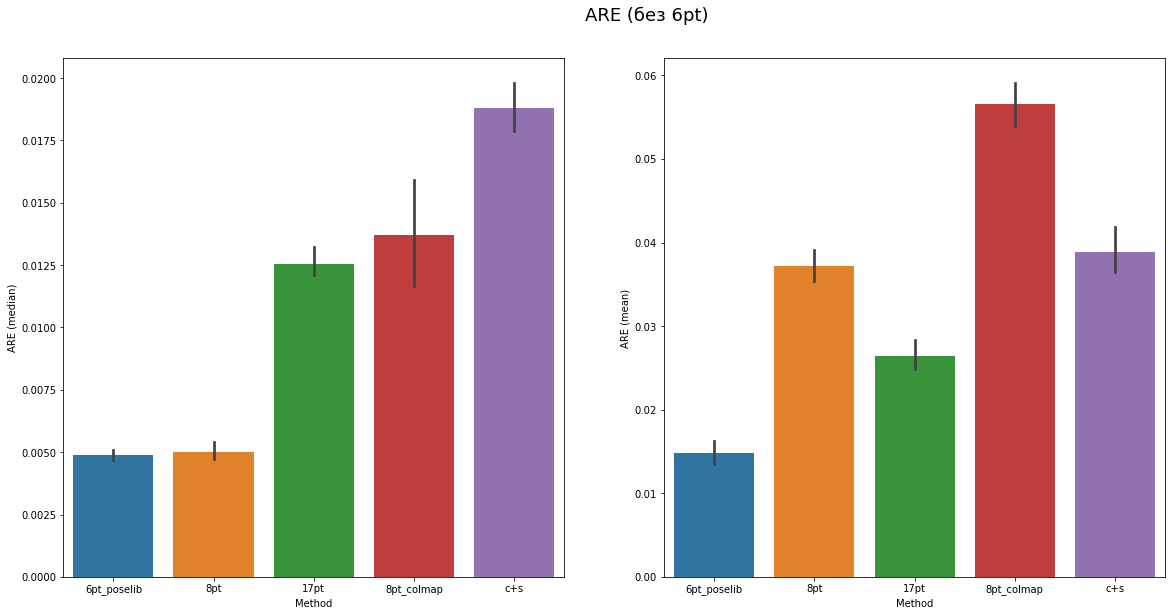

In [117]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('ARE (без 6pt)', fontsize=18)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df[~stability_df["method_name"].isin(["6pt", "6pt_opengv_raw"])].groupby(["method_name"])['ARE'].aggregate(np.median).reset_index().sort_values('ARE')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="ARE", 
            data=stability_df[~stability_df["method_name"].isin(["6pt", "6pt_opengv_raw"])],
            estimator=est,
            order=order['method_name']
        )
        axes[i].set(ylabel=f"ARE ({est_name})", xlabel="Method")

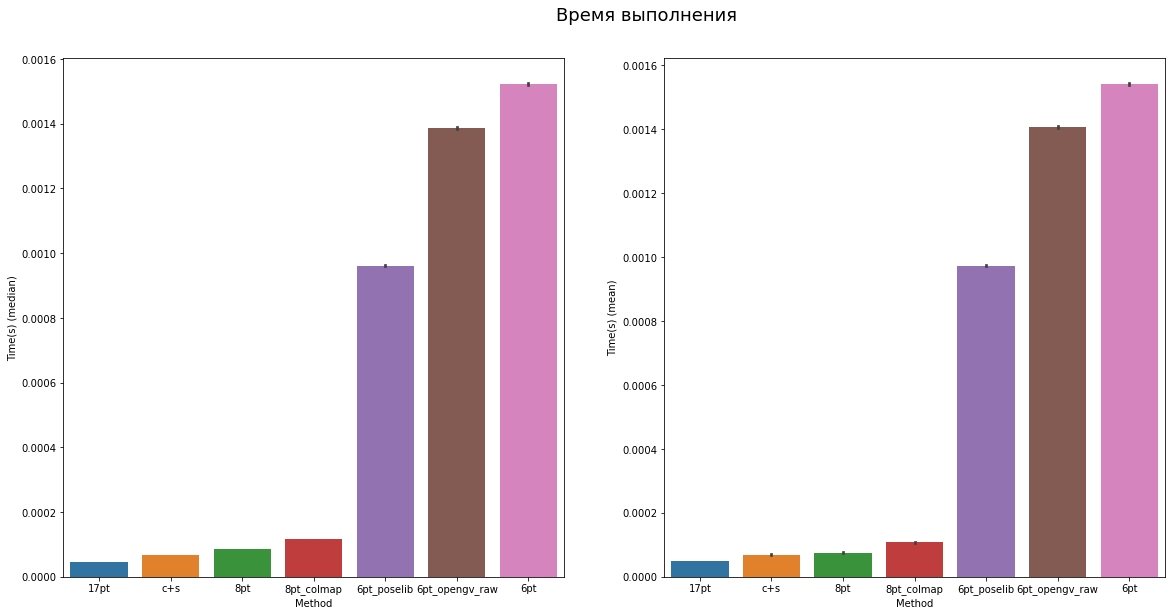

In [91]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Время выполнения', fontsize=18)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df.groupby(["method_name"])['time'].aggregate(np.median).reset_index().sort_values('time')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="time", 
            data=stability_df,
            estimator=est,
            order=order['method_name']
        )
        axes[i].set(ylabel=f"Time(s) ({est_name})", xlabel="Method")
